In [1]:
# for array computations and loading data
import numpy as np

# for building linear regression models and preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

# for building and training neural networks
import tensorflow as tf
import matplotlib.pyplot as plt

# custom functions
import utils

# reduce display precision on numpy arrays
#np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [2]:
# Load the dataset from the text file
data = np.loadtxt('./110data.txt', delimiter=',')

# Split the inputs and outputs into separate arrays
x = data[:,0]
y = data[:,1]

# Convert 1-D arrays into 2-D because the commands later will require it
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)

print(f"the shape of the inputs x is: {x.shape}")
print(f"the shape of the targets y is: {y.shape}")

the shape of the inputs x is: (104, 1)
the shape of the targets y is: (104, 1)


In [3]:
# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_.
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

# Data Preparation for XGBoost
X_train = x_train
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")
print(f"the shape of the new XGBoost training set (input) is: {X_train_fit.shape}")
print(f"the shape of the new XGBoost training set (target) is: {y_train_fit.shape}")
print(f"the shape of the XGBoost evaluation set (input) is: {X_train_eval.shape}")
print(f"the shape of the XGBoost evaluation set (target) is: {y_train_eval.shape}")

the shape of the training set (input) is: (62, 1)
the shape of the training set (target) is: (62, 1)

the shape of the cross validation set (input) is: (21, 1)
the shape of the cross validation set (target) is: (21, 1)

the shape of the test set (input) is: (21, 1)
the shape of the test set (target) is: (21, 1)
the shape of the new XGBoost training set (input) is: (49, 1)
the shape of the new XGBoost training set (target) is: (49, 1)
the shape of the XGBoost evaluation set (input) is: (13, 1)
the shape of the XGBoost evaluation set (target) is: (13, 1)


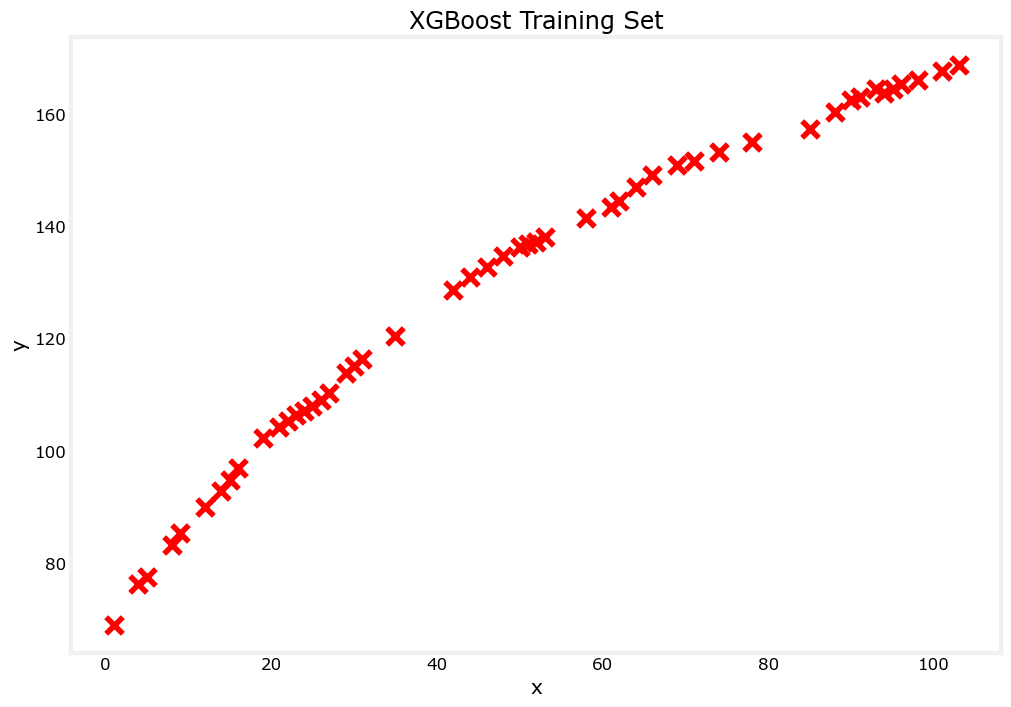

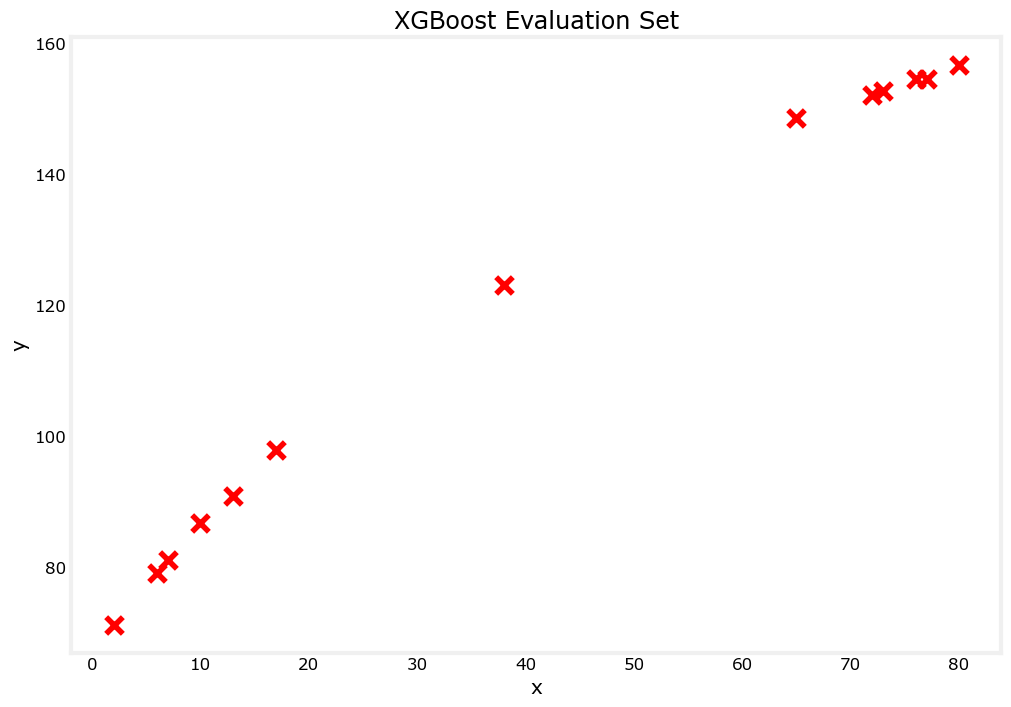

In [4]:
utils.plot_dataset(x=X_train_fit, y=y_train_fit, title="XGBoost Training Set")
utils.plot_dataset(x=X_train_eval, y=y_train_eval, title="XGBoost Evaluation Set")

In [5]:
# Instantiate the class
#scaler_linear = StandardScaler()
scaler_linear = MinMaxScaler()

# Compute the mean and standard deviation of the training set and the evaluation set then transform it
X_train_fit_scaled = scaler_linear.fit_transform(X_train_fit)
X_train_eval_scaled = scaler_linear.transform(X_train_eval)

In [6]:
# Initialize the class
#model = LinearRegression()
xgb_model = XGBRegressor()

# Train the model
#xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)
xgb_model.fit(X_train_fit_scaled, y_train_fit)
#xgb_model.best_iteration

# Feed the scaled training set, get the predictions and use scikit-learn's utility function “mean_squared_error”
yhat_fit = xgb_model.predict(X_train_fit_scaled)
print(f"Training MSE (using sklearn function): {mean_squared_error(y_train_fit, yhat_fit) / 2}")

# Feed the scaled evaluation set and compute the cross validation MSE
yhat_eval = xgb_model.predict(X_train_eval_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_train_eval, yhat_eval) / 2}")

# Predict next 6 points
pred_point = 6
data_points = 104
future_x = np.arange(data_points, data_points + pred_point).reshape(-1, 1)  # Predict points 104 to 110
future_x_scaled = scaler_linear.transform(future_x)

# Evaluate the future predictions 
yhat_xgboost = xgb_model.predict(future_x_scaled)
print(f"\nForecast values:",
          f"\n{yhat_xgboost}")

Training MSE (using sklearn function): 3.3405022486602716e-06
Cross validation MSE: 1.5898620250198454

Forecast values: 
[168.85832 168.85832 168.85832 168.85832 168.85832 168.85832]


In [7]:
# Fixed the parentheses issue - mean_squared_error takes two arguments, not a tuple
# And moved the division by 2 inside the function call
print(f"Metrics fit:\n\tMSE: {mean_squared_error(y_train_fit, yhat_fit) / 2:.6f}\n\tR²: {r2_score(y_train_fit, yhat_fit):.6f}")
print(f"Metrics eval:\n\tMSE: {mean_squared_error(y_train_eval, yhat_eval) / 2:.6f}\n\tR²: {r2_score(y_train_eval, yhat_eval):.6f}")

Metrics fit:
	MSE: 0.000003
	R²: 1.000000
Metrics eval:
	MSE: 1.589862
	R²: 0.997179


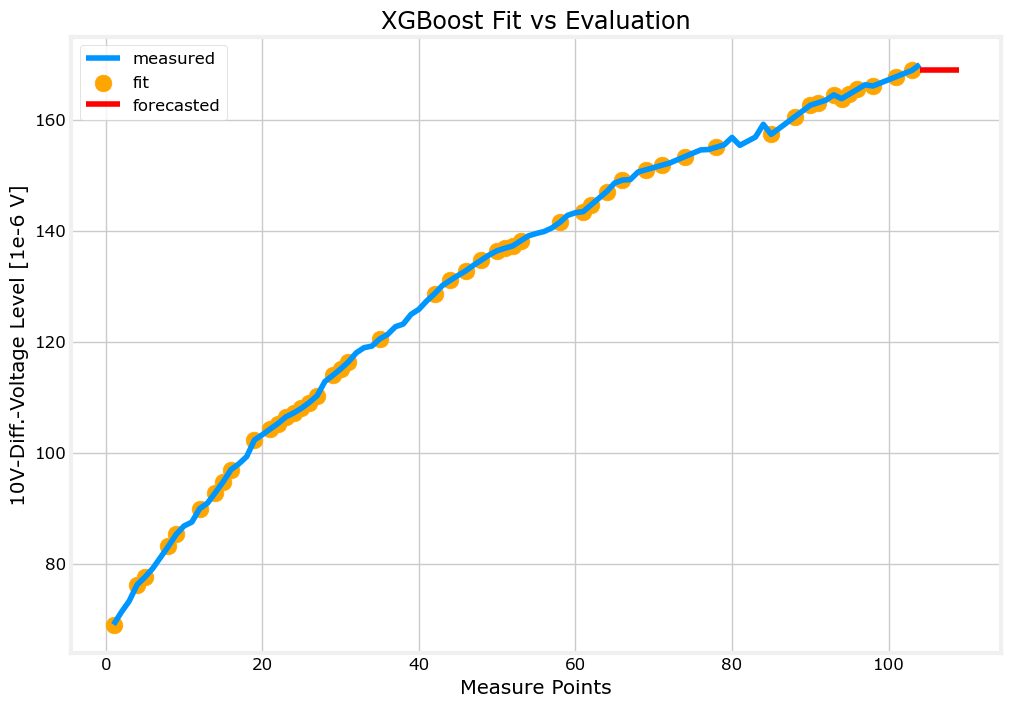

In [8]:
# Plot XGBoost Fit vs Evaluation
x_train_fit = X_train_fit.reshape(-1, 1)
x_train_eval = X_train_eval.reshape(-1, 1)
future_x_plot = np.arange(len(future_x))

plt.plot(x, y, label='measured')
plt.scatter(x_train_fit, yhat_fit, color='orange', label='fit')
#plt.scatter(x_train_eval, yhat_eval, color='orange', label='eval')
plt.plot(future_x_plot+data_points, yhat_xgboost, color='red', label='forecasted')
plt.xlabel("Measure Points")
plt.ylabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.title("XGBoost Fit vs Evaluation")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the XGBoost set
X_train_mapped = poly.fit_transform(X_train_fit)

# Instantiate the class
#scaler_poly = StandardScaler()
scaler_poly = MinMaxScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Initialize the class
#model = LinearRegression()
xgb_model = XGBRegressor()

# Train the model
xgb_model.fit(X_train_mapped_scaled, y_train_fit)

# Compute the training MSE
yhat_fit = xgb_model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train_fit, yhat_fit) / 2}")

# Add the polynomial features to the XGBoost evaluation set
X_eval_mapped = poly.transform(X_train_eval)

# Scale the XGBoost evaluation set using the mean and standard deviation of the XGBoost Fit set
X_cv_mapped_scaled = scaler_poly.transform(X_eval_mapped)

# Compute the evaluation MSE
yhat_eval = xgb_model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_train_eval, yhat_eval) / 2}")

Training MSE: 3.3405022486602716e-06
Cross validation MSE: 1.5898620250198454


Test MSE: 1.2082596253981523


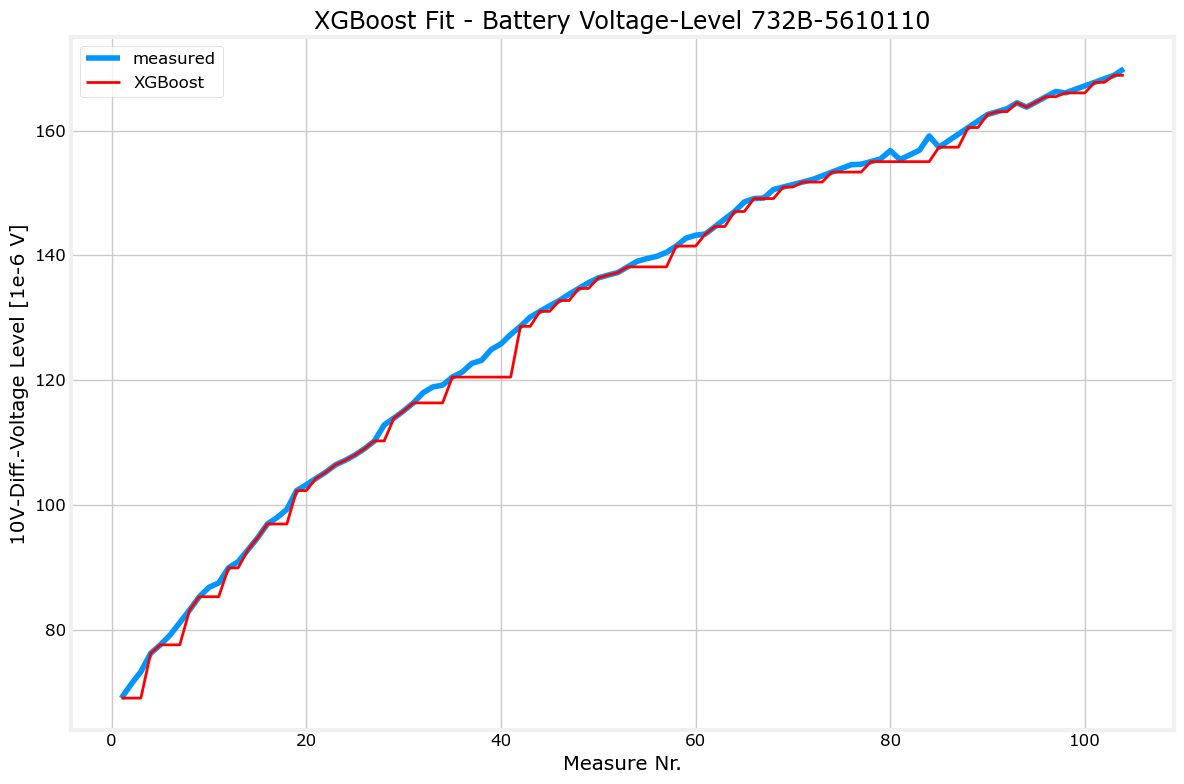

In [10]:
# Add polynomial features to the test set
#X_test_mapped = polys[degree-1].transform(x_test)
X_mapped = poly.transform(x)

# Scale the test set
#X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)
X_mapped_scaled = scaler_poly.transform(X_mapped)

# Compute the test MSE
#yhat = models[degree-1].predict(X_test_mapped_scaled)
#test_mse = mean_squared_error(y_test, yhat) / 2
yhat_x = xgb_model.predict(X_mapped_scaled)
test_mse = mean_squared_error(y, yhat_x) / 2

print(f"Test MSE: {test_mse}")

plt.plot(x, y, label='measured')
#plt.scatter(x_test, yhat, alpha=0.2, color='red', label='model-valued')
plt.plot(x, yhat_x, color='red', lw=2, label='XGBoost')
plt.title(f"XGBoost Fit - Battery Voltage-Level 732B-5610110")
plt.xlabel("Measure Nr.")
plt.ylabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

In [11]:
# Instantiate the class to make polynomial features
#poly = PolynomialFeatures(degree=2, include_bias=False)

# Compute the number of features and transform the XGBoost set
#X_train_mapped = poly.fit_transform(X_train_fit)

# Instantiate the class
#scaler_poly = StandardScaler()
scaler_linear = MinMaxScaler()

# Compute the mean and standard deviation of the training set then transform it
X_train_fit_scaled = scaler_linear.fit_transform(X_train_fit)

# Initialize the class
#model = LinearRegression()
xgb_model = XGBRegressor()

# Train the model
xgb_model.fit(X_train_fit_scaled, y_train_fit)

# Feed the scaled XGBoost set, get the predictions and use scikit-learn's utility function “mean_squared_error”
yhat_fit = xgb_model.predict(X_train_fit_scaled)
print(f"XGBoost Fit MSE: {mean_squared_error(y_train_fit, yhat_fit) / 2}")

# Feed the scaled evaluation set and compute the cross validation MSE
yhat_eval = xgb_model.predict(X_train_eval_scaled)
print(f"XGBoost Eval MSE: {mean_squared_error(y_train_eval, yhat_eval) / 2}")

XGBoost Fit MSE: 3.3405022486602716e-06
XGBoost Eval MSE: 1.5898620250198454


In [12]:
# Compute the mean and standard deviation of the training set then transform it
X_fit_scaled = scaler_linear.fit_transform(x)

# Initialize the class
#model = LinearRegression()
xgb_model = XGBRegressor()

# Train the model
xgb_model.fit(X_fit_scaled, y)

# Feed the scaled XGBoost set, get the predictions and use scikit-learn's utility function “mean_squared_error”
yhat_fit = xgb_model.predict(X_fit_scaled)
print(f"XGBoost X-Fit MSE: {mean_squared_error(y, yhat_fit) / 2}")

XGBoost X-Fit MSE: 0.00024485322536468276


Test MSE: 0.00024485322536468276


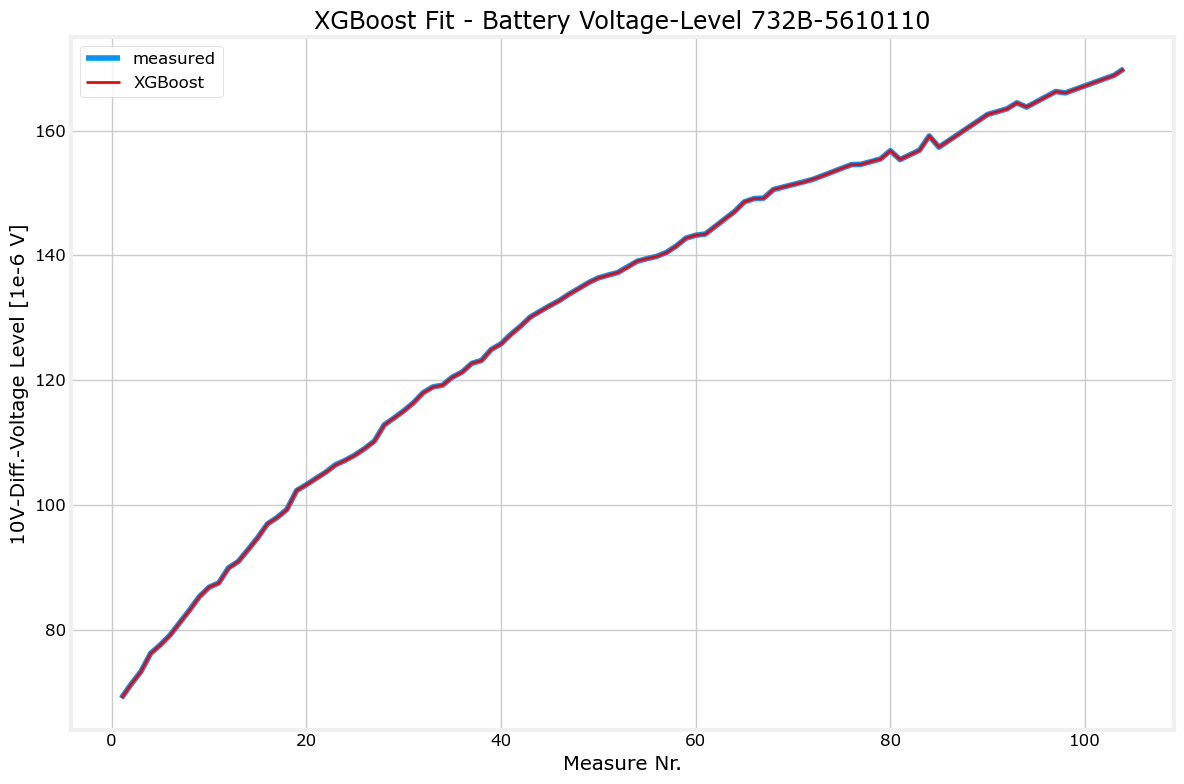

In [13]:
# Compute the test MSE
#yhat = models[degree-1].predict(X_test_mapped_scaled)
#test_mse = mean_squared_error(y_test, yhat) / 2
yhat_x = xgb_model.predict(X_fit_scaled)
test_mse = mean_squared_error(y, yhat_x) / 2

print(f"Test MSE: {test_mse}")

plt.plot(x, y, label='measured')
#plt.scatter(x_test, yhat, alpha=0.2, color='red', label='model-valued')
plt.plot(x, yhat_x, lw=2, color='red', label='XGBoost')
plt.title(f"XGBoost Fit - Battery Voltage-Level 732B-5610110")
plt.xlabel("Measure Nr.")
plt.ylabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

In [14]:
# Fixed the parentheses issue - mean_squared_error takes two arguments, not a tuple
# And moved the division by 2 inside the function call
print(f"Metrics fit:\n\tMSE: {mean_squared_error(y, yhat_x) / 2:.6f}\n\tR²: {r2_score(y, yhat_x):.6f}")
#print(f"Metrics eval:\n\tMSE: {mean_squared_error(y_train_eval, yhat_eval) / 2:.6f}\n\tR²: {r2_score(y_train_eval, yhat_eval):.6f}")

Metrics fit:
	MSE: 0.000245
	R²: 0.999999


In [15]:
# Predict next 6 points
pred_point = 6
data_points = 104
future_x = np.arange(data_points, data_points + pred_point).reshape(-1, 1)  # Predict points 104 to 110
future_x_scaled = scaler_linear.transform(future_x)

# Evaluate the future predictions 
yhat_forecast = xgb_model.predict(future_x_scaled)
print(f"\nForecast values:",
          f"\n{yhat_forecast}")


Forecast values: 
[169.89018 169.89018 169.89018 169.89018 169.89018 169.89018]


Test MSE: 0.00024485322536468276
Metrics fit:
	MSE: 0.000245
	R²: 0.999999

Forecast values: 
[169.89018 169.89018 169.89018 169.89018 169.89018 169.89018]


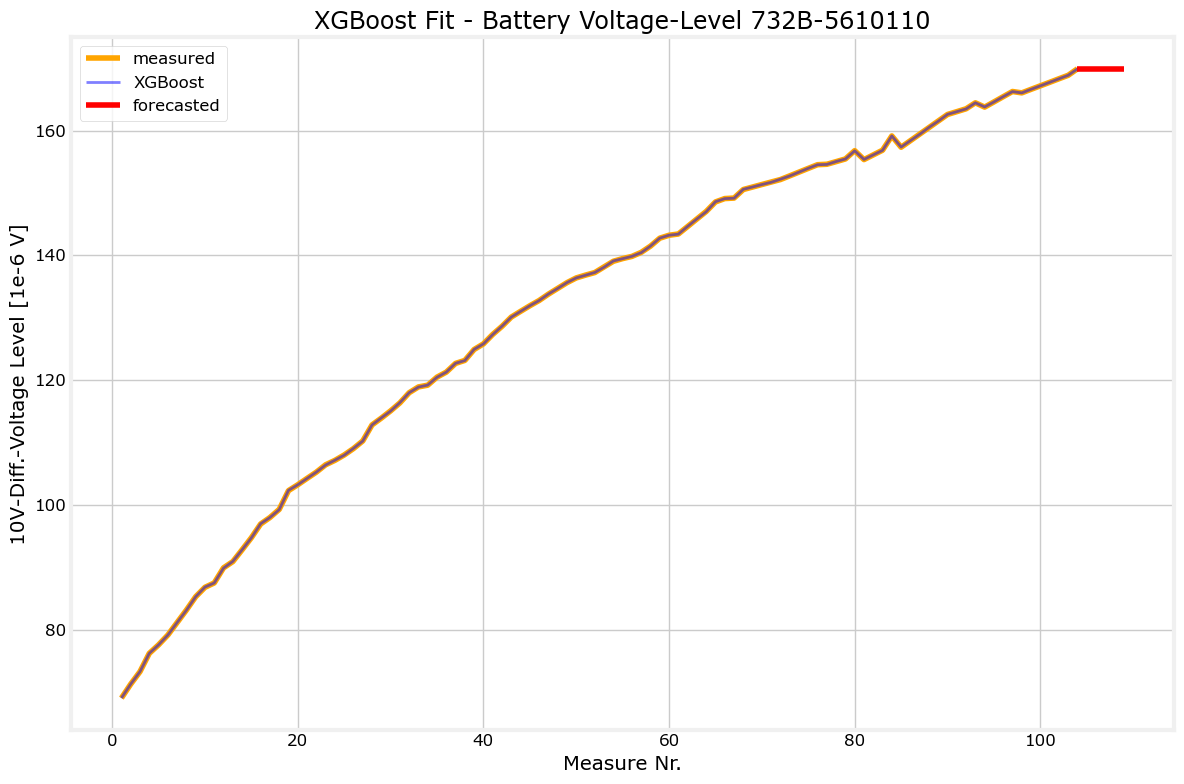

In [16]:
# Compute the test MSE
#yhat = models[degree-1].predict(X_test_mapped_scaled)
#test_mse = mean_squared_error(y_test, yhat) / 2
yhat_x = xgb_model.predict(X_fit_scaled)
test_mse = mean_squared_error(y, yhat_x) / 2

print(f"Test MSE: {test_mse}")
print(f"Metrics fit:\n\tMSE: {mean_squared_error(y, yhat_x) / 2:.6f}\n\tR²: {r2_score(y, yhat_x):.6f}")

# Evaluate the future predictions 
yhat_forecast = xgb_model.predict(future_x_scaled)
print(f"\nForecast values:",
          f"\n{yhat_forecast}")

plt.plot(x, y,color='orange', label='measured')
#plt.scatter(x_test, yhat, alpha=0.2, color='red', label='model-valued')
plt.plot(x, yhat_x, lw=2, color='blue', alpha=0.5, label='XGBoost')
plt.plot(future_x_plot+data_points, yhat_forecast, color='red', label='forecasted')
plt.title(f"XGBoost Fit - Battery Voltage-Level 732B-5610110")
plt.xlabel("Measure Nr.")
plt.ylabel("10V-Diff.-Voltage Level [1e-6 V]")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

In [17]:
print(yhat_x)

[ 69.04326   71.27238   73.27318   76.20097   77.56993   79.131935
  81.14234   83.11281   85.28301   86.83139   87.48815   89.86557
  90.941376  92.79888   94.70983   96.98448   97.9786    99.240715
 102.33895  103.22544  104.245155 105.25738  106.39575  107.16729
 107.96669  109.06055  110.225685 112.816895 113.93764  115.03832
 116.389854 117.984276 118.884125 119.21253  120.45981  121.282646
 122.69737  123.13976  124.93508  125.80447  127.299126 128.6399
 130.09557  131.01413  131.92542  132.75502  133.79623  134.6921
 135.63527  136.38257  136.81422  137.25601  138.10173  139.09723
 139.46677  139.84425  140.43297  141.48987  142.75865  143.22469
 143.40187  144.64055  145.83322  146.98784  148.59567  149.09285
 149.154    150.58624  150.95508  151.34866  151.7086   152.20091
 152.7291   153.33858  153.95143  154.52261  154.57152  155.04126
 155.44414  156.75523  155.3722   156.10512  156.8265   159.13725
 157.3606   158.38426  159.40477  160.50774  161.50677  162.59659
 163.0285

In [18]:
print(yhat_x.shape)

(104,)


In [20]:
print(yhat_x.reshape(-1,1))

[[ 69.04326 ]
 [ 71.27238 ]
 [ 73.27318 ]
 [ 76.20097 ]
 [ 77.56993 ]
 [ 79.131935]
 [ 81.14234 ]
 [ 83.11281 ]
 [ 85.28301 ]
 [ 86.83139 ]
 [ 87.48815 ]
 [ 89.86557 ]
 [ 90.941376]
 [ 92.79888 ]
 [ 94.70983 ]
 [ 96.98448 ]
 [ 97.9786  ]
 [ 99.240715]
 [102.33895 ]
 [103.22544 ]
 [104.245155]
 [105.25738 ]
 [106.39575 ]
 [107.16729 ]
 [107.96669 ]
 [109.06055 ]
 [110.225685]
 [112.816895]
 [113.93764 ]
 [115.03832 ]
 [116.389854]
 [117.984276]
 [118.884125]
 [119.21253 ]
 [120.45981 ]
 [121.282646]
 [122.69737 ]
 [123.13976 ]
 [124.93508 ]
 [125.80447 ]
 [127.299126]
 [128.6399  ]
 [130.09557 ]
 [131.01413 ]
 [131.92542 ]
 [132.75502 ]
 [133.79623 ]
 [134.6921  ]
 [135.63527 ]
 [136.38257 ]
 [136.81422 ]
 [137.25601 ]
 [138.10173 ]
 [139.09723 ]
 [139.46677 ]
 [139.84425 ]
 [140.43297 ]
 [141.48987 ]
 [142.75865 ]
 [143.22469 ]
 [143.40187 ]
 [144.64055 ]
 [145.83322 ]
 [146.98784 ]
 [148.59567 ]
 [149.09285 ]
 [149.154   ]
 [150.58624 ]
 [150.95508 ]
 [151.34866 ]
 [151.7086  ]
 [152.